In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

%matplotlib ipympl

%load_ext autoreload
%autoreload 2

import sys

sys.path.append('.')
sys.path.append('..')

In [2]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from typing import Tuple

import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from shapely.geometry import Polygon

from utils.plotting import to_colors
from utils.misc import load_obj_file, bounded_voronoi

from itertools import product
import subprocess

from ndgsp import UnivariateFilterFunction, MultivariateFilterFunction, Graph, ProductGraph

import ast
from tqdm.notebook import trange, tqdm

Using Jax backend with device gpu:0


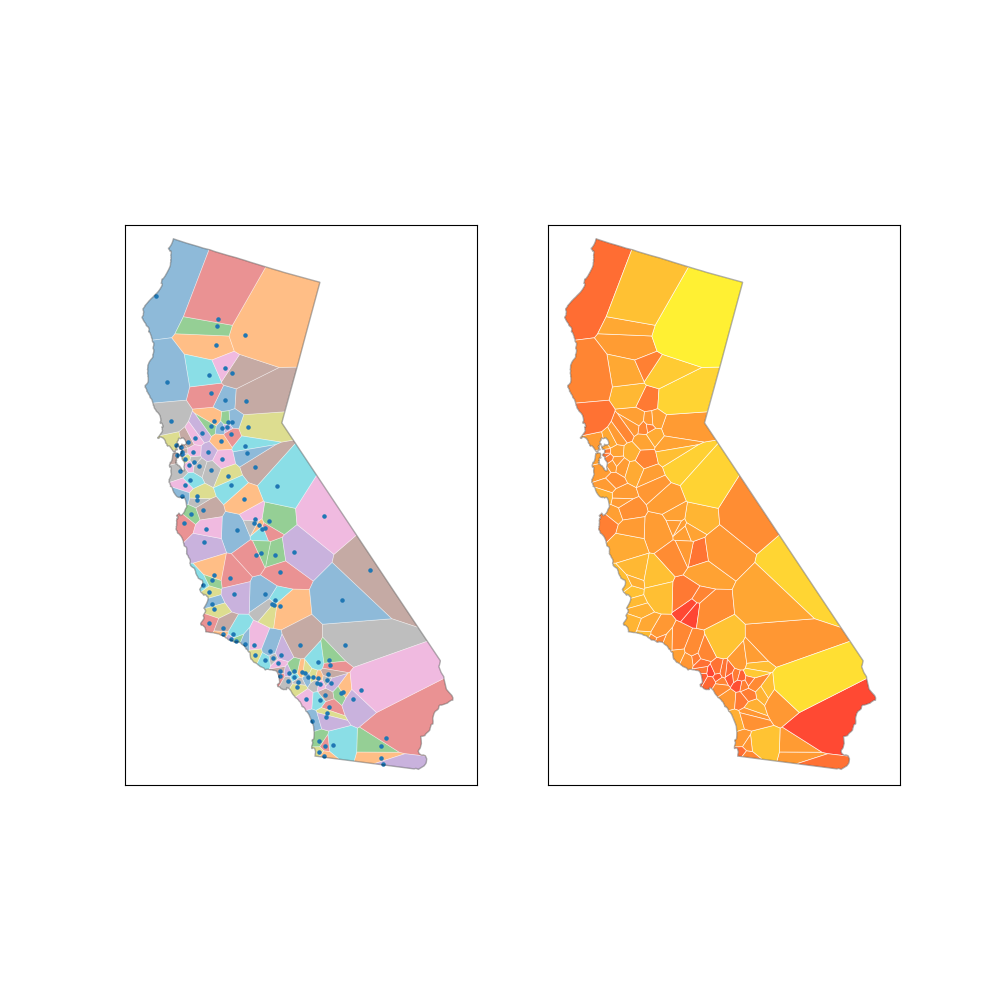

In [3]:

def cali_plot(save=False):
    """
    Plot a map of California with vononoi regions
    """

    sites = pd.read_csv('../data/cali/sites.csv', index_col=0)
    data = pd.read_csv('../data/cali/Ozone.csv', index_col=0, parse_dates=True)
    sites = sites.loc[data.columns]

    cali = np.load('../data/cali/cali_xy.npy')

    contained = Path(cali).contains_points(sites[['x', 'y']].values)

    regions = bounded_voronoi(points=sites.loc[contained, ['x', 'y']], boundary=cali)

    def add_patches(ax, regions, colors=None, alpha=0.5):

        default_colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


        if colors is None:
            colors = default_colors[np.arange(len(regions)) % len(default_colors)]

        for i, region in enumerate(regions):

            for sub_region in region:

                ax.add_patch(PathPatch(Path(sub_region), alpha=alpha, facecolor=colors[i], edgecolor='white', linewidth=0.5))

        
    cols = to_colors(data.iloc[:4, contained].values, cmap='autumn')

    fig, axes = plt.subplots(figsize=(10, 10), ncols=2)

    add_patches(axes[0], regions, colors=None, alpha=0.5)
    axes[0].scatter(sites.loc[contained, 'x'], sites.loc[contained, 'y'], s=5)

    add_patches(axes[1], regions, colors=cols[3, :], alpha=0.8)

    for ax in axes:

        ax.add_patch(PathPatch(Path(cali), alpha=0.3, facecolor="none", edgecolor='black'))
        ax.set_xlim(-2.4e6, -1.6e6)
        ax.set_ylim(-5.5e5, 7.2e5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

    if save:

        plt.savefig('cali_plot.pdf')

        subprocess.run(['pdfcrop', 'cali_plot.pdf', 'cali_plot.pdf'])


cali_plot()

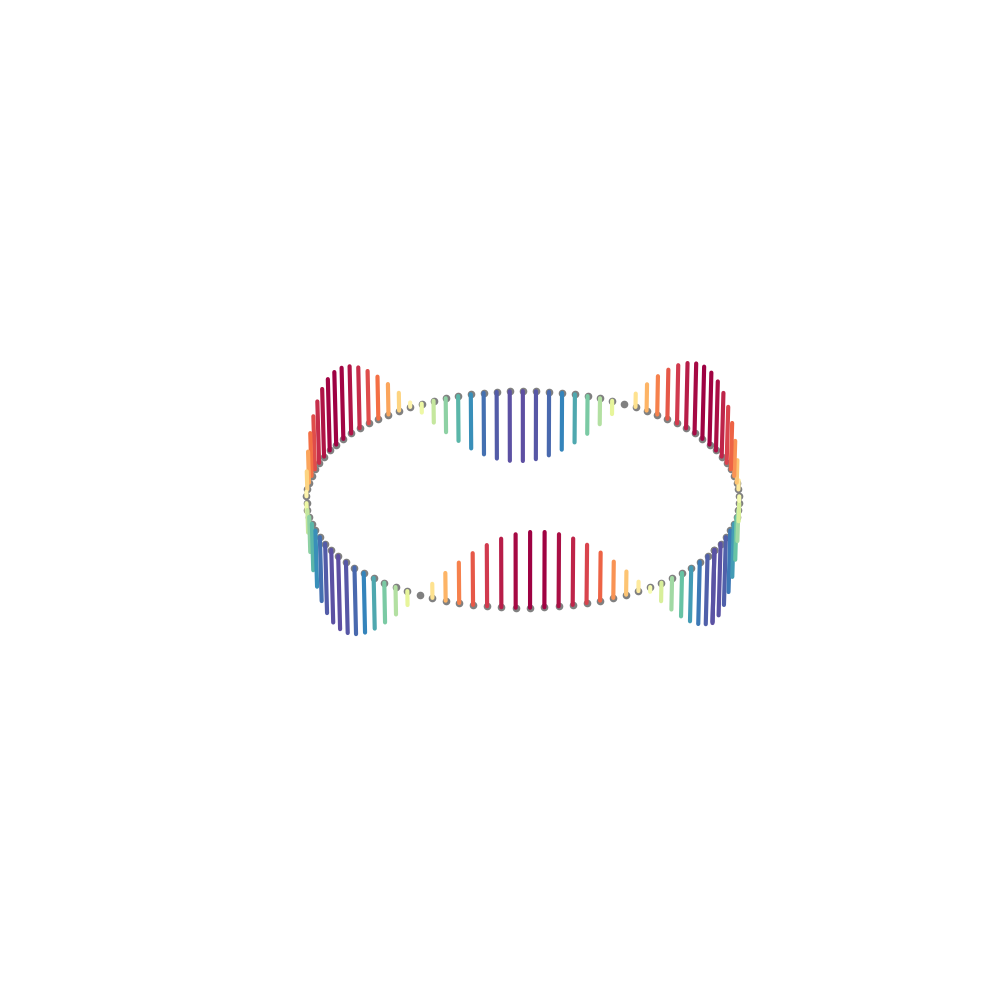

In [4]:
def plot_loop_graph(n, save=False):
    """
    Plot the nth eigenvector of the loop graph
    """
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d',computed_zorder=False)

    theta = np.linspace(0, 2 * np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)

    g = Graph.loop(100)
    ax.scatter(x, y, np.zeros(100), depthshade=False, color='gray', zorder=-1)
    
    if n == 0: 
        cols = [to_colors(-g.U[:,0], cmap='Spectral')[86]] * 100
    else:
        cols = to_colors(-g.U[:, n], cmap='Spectral')

    for xi, yi, zi, c in zip(x, y, g.U[:, n], cols):

        ax.plot([xi, xi], [yi, yi], [0, zi], color=c, lw=3, solid_capstyle='round')

    ax.set_zlim(-0.3, 0.3)
    ax.axis('off')

    if save:
        
        plt.savefig(f'loop_plot/loop_graph_{n}.pdf')
        subprocess.run(['pdfcrop', f'loop_plot/loop_graph_{n}.pdf', f'loop_plot/loop_graph_{n}.pdf'])


    
plot_loop_graph(5)

In [19]:
%%capture 

for i in range(9):
    
    plot_loop_graph(i, save=True)

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `loop_plot/loop_graph_0.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `loop_plot/loop_graph_1.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `loop_plot/loop_graph_2.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `loop_plot/loop_graph_3.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `loop_plot/loop_graph_4.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `loop_plot/loop_graph_5.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdi

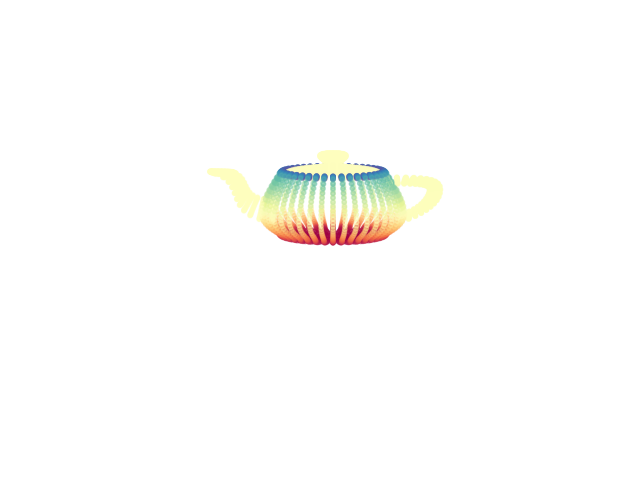

In [5]:
def plot_teapot(n, save=False):
    """
    Plot the n-th eigenvector of the teapot graph
    """
    
    w = load_obj_file('../data/teapot/teapot.obj',  triangulate=False)

    y, z, x = np.array(w.vertices).T
    edges = np.array(sum([[(v1[0], v2[0]) for v1, v2 in zip(poly[:-1], poly[1:])] for poly in w.polygons], []))
    xi, yi = edges.T

    A = np.zeros((3241, 3241), dtype=bool)
    A[xi, yi] = True
    A[yi, xi] = True
    
    teapot_graph = Graph.from_adjacency(A)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    if n == 0: 
        cols = [to_colors(teapot_graph.U[:, 0], cmap='Spectral')[int(0.86 * len(teapot_graph.U[:, 0]))]] * len(teapot_graph.U[:, 0])
    else:
        cols = to_colors(-teapot_graph.U[:, n], cmap='Spectral')
        
    ax.scatter(x, y, z, c=cols, s=10, alpha=0.5)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    ax.set_xlim(-3.2, 3.2)
    ax.set_ylim(-3.2, 3.2)
    ax.set_zlim(-3.2, 3.2)

    plt.axis('off')

    ax.view_init(8, -90)

    if save:

        plt.savefig(f'teapot_plot/teapot_{n}.pdf')

        subprocess.run(['pdfcrop', f'teapot_plot/teapot_{n}.pdf', f'teapot_plot/teapot_{n}.pdf'])


plot_teapot(4)

In [144]:
%%capture

for i in range(9):
    plot_teapot(i, save=True)

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `teapot_plot/teapot_0.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `teapot_plot/teapot_1.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `teapot_plot/teapot_2.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `teapot_plot/teapot_3.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `teapot_plot/teapot_4.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `teapot_plot/teapot_5.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package S

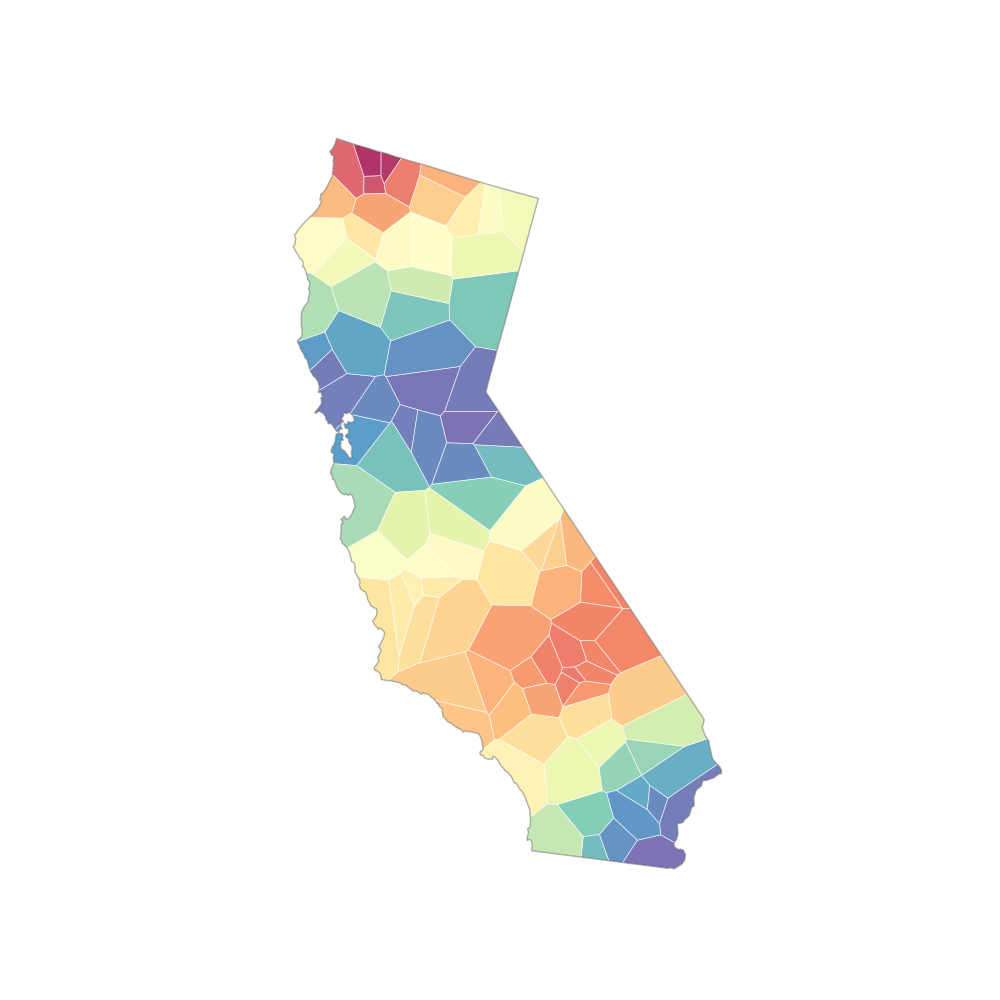

In [6]:
def plot_cali_eigs(n, save=False):
    """
    Plot the n-th eigenvector of the california graph
    """
    
    cali = np.load('../data/cali/cali_xy.npy')
    
    xmin = cali[:, 0].min()
    xmax = cali[:, 0].max()
    ymin = cali[:, 1].min()
    ymax = cali[:, 1].max()
    
    np.random.seed(0)
    points = np.random.uniform(low=(xmin, ymin), high=(xmax, ymax), size=(200, 2))

    contained = Path(cali).contains_points(points)

    regions = bounded_voronoi(points=points[contained], boundary=cali)
    
    A = np.zeros((len(regions), len(regions)))

    paths = [[Path(sub_region) for sub_region in region] for region in regions]

    for i, paths1 in enumerate(paths):

        for j, paths2 in enumerate(paths):

            if i == j:

                break

            if any(p1.intersects_path(p2) for p1, p2 in product(paths1, paths2)):

                A[i, j] = A[j, i] = 1
                
    g = Graph.from_adjacency(A)

    def add_patches(ax, regions, colors, alpha=0.5):

        for i, region in enumerate(regions):

            for sub_region in region:

                ax.add_patch(PathPatch(Path(sub_region), alpha=alpha, facecolor=colors[i], edgecolor='white', linewidth=0.5))

        
    if n == 0: 
        cols = ['#9E0142'] * len(g.U[:, 0])
    else:
        cols = to_colors(g.U[:, n], cmap='Spectral')
        
    fig, ax = plt.subplots(figsize=(10, 10))

    add_patches(ax, regions, colors=cols, alpha=0.8)

    ax.add_patch(PathPatch(Path(cali), alpha=0.3, facecolor="none", edgecolor='black'))
    ax.set_xlim(-2.4e6, -1.6e6)
    ax.set_ylim(-5.5e5, 7.2e5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    
    ax.axis('off')

    if save: 

        plt.savefig(f'cali_plot/cali_{n}.pdf')

        subprocess.run(['pdfcrop', f'cali_plot/cali_{n}.pdf', f'cali_plot/cali_{n}.pdf'])

plot_cali_eigs(3)

In [184]:
%%capture

for i in range(9):
    plot_cali_eigs(i)

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `cali_plot/cali_0.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `cali_plot/cali_1.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `cali_plot/cali_2.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `cali_plot/cali_3.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `cali_plot/cali_4.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `cali_plot/cali_5.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page

In [8]:
regions = pd.read_csv('../data/uk/regions.csv', index_col=0).drop('E07000008')
regions['coords'] = regions['coords'].apply(lambda item: ast.literal_eval(item))  


def get_district_graph(regions):
    """
    Get a graph representing the districts in the UK
    """

    paths = {code: [Path(np.squeeze(coords)) for coords in coords_list] for code, coords_list in zip(regions.index.tolist(), regions['coords'])}

    A = np.zeros((len(paths), len(paths)))

    for i, plist1 in tqdm(enumerate(paths.values()), total=A.shape[0]):

        for j, plist2 in enumerate(paths.values()):

            if i == j:
                break

            for path1 in plist1:
                for path2 in plist2:
                    if path1.intersects_path(path2):
                        A[i, j] = 1
                        A[j, i] = 1
                        
    for pair in [['S12000013', 'S12000017'], 
                 ['E06000046', 'E07000091'], 
                 ['W06000001', 'W06000002'], 
                 ['S12000027', 'S12000023'], 
                 ['S12000023', 'S12000017'], 
                 ['N09000010', 'W06000001'], 
                 ['N09000011', 'S12000006']]:
        
        i = regions.index.tolist().index(pair[0])
        j = regions.index.tolist().index(pair[1])
        A[i, j] = 1
        A[j, i] = 1

    L  = np.diag(A.sum(0)) - A
    
    return A, L

A, L = get_district_graph(regions)
g = Graph.from_adjacency(A)



  0%|          | 0/371 [00:00<?, ?it/s]

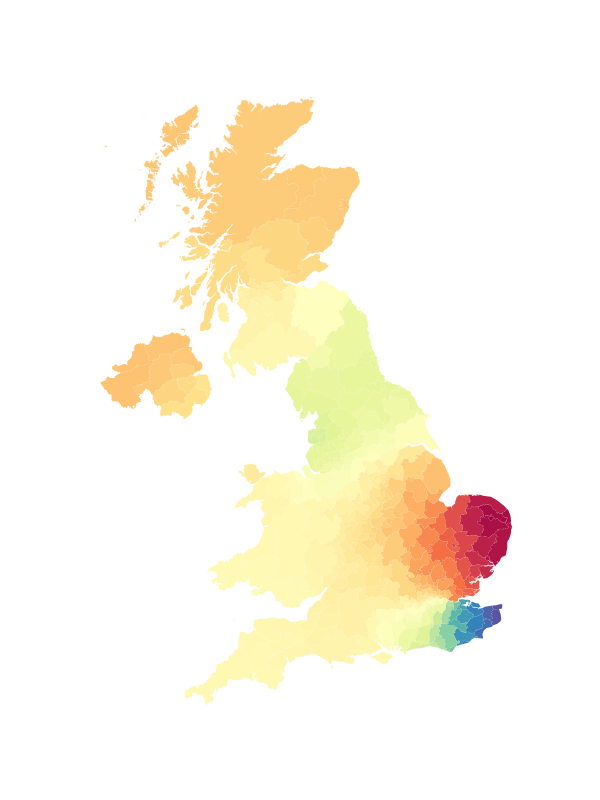

In [9]:

def plot_uk_eigs(n, save=False):
    """
    Plot the nth eigenvector of the uk district graph
    """
    
    patches = {}

    vmin = 50
    vmax = 225
    
    if n == 0: 
        cols = ['#9E0142'] * len(g.U[:, 0])
    else:
        cols = to_colors(-g.U[:, n], cmap='Spectral')    
        
    fig, ax = plt.subplots(figsize=(6, 8))

    for code, coord_list, color in zip(regions.index, regions['coords'], cols):
        
        patches[code] = []

        for coords in coord_list:

            coords = np.squeeze(coords)
            patches[code].append(ax.add_patch(PathPatch(Path(coords), facecolor=color, edgecolor='white', linewidth=0)))
                        
    ax.set_xlim(0, 0.66e6)
    ax.set_ylim(0, 0.98e6)
    
    ax.set_aspect('equal')
    plt.axis('off')

    if save:

        plt.savefig(f'uk_plot/uk_{n}.pdf')
        subprocess.run(['pdfcrop', f'uk_plot/uk_{n}.pdf', f'uk_plot/uk_{n}.pdf'])

plot_uk_eigs(5)

In [143]:
%%capture

for i in range(9):
    
    plot_uk_eigs(i, save=True)

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `uk_plot/uk_0.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `uk_plot/uk_1.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `uk_plot/uk_2.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `uk_plot/uk_3.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `uk_plot/uk_4.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `uk_plot/uk_5.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `uk_plot/uk_

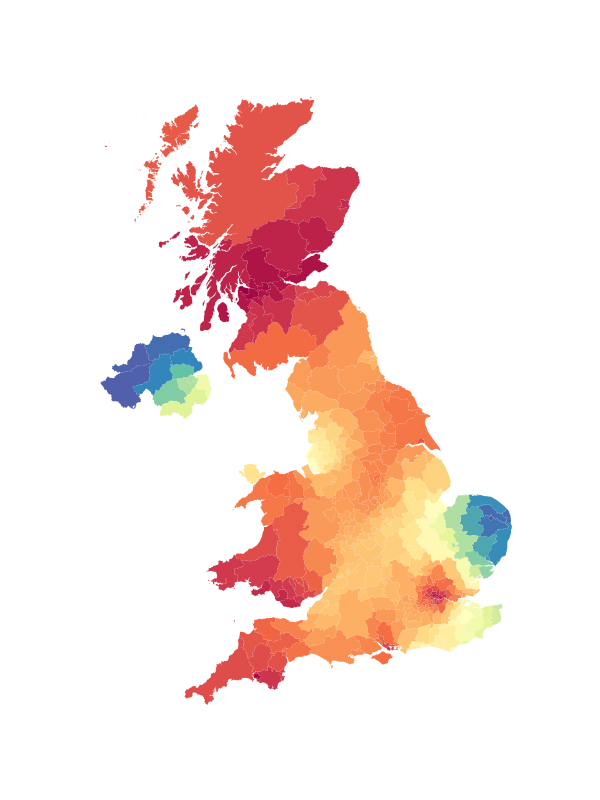

In [10]:
def plot_uk_random(seed=6, save=False):
    """
    Plot a random signal for the uk
    """
    
    patches = {}

    np.random.seed(seed)
    
    sig = g.U[:, :20] @ np.random.normal(size=20)
    
    cols = to_colors(sig, cmap='Spectral')            
    fig, ax = plt.subplots(figsize=(6, 8))

    for code, coord_list, color in zip(regions.index, regions['coords'], cols):
        
        patches[code] = []

        for coords in coord_list:

            coords = np.squeeze(coords)
            patches[code].append(ax.add_patch(PathPatch(Path(coords), facecolor=color, edgecolor='white', linewidth=0)))
                        
    ax.set_xlim(0, 0.66e6)
    ax.set_ylim(0, 0.98e6)
    
    ax.set_aspect('equal')
    plt.axis('off')

    if save:

        plt.savefig(f'uk_smooth.pdf')
        subprocess.run(['pdfcrop', f'uk_smooth.pdf', f'uk_smooth.pdf'])
    
plot_uk_random()